# [`climate4R`](https://github.com/SantanderMetGroup/climate4R) Jupyter Hub. IPCC-AR6 WGI Atlas 
## Meteorology Group, [IFCA](http://ifca.unican.es), CSIC - Univ. of Cantabria)
## Code for regional analysis of CMIP5 indices to produce Atlas FOD figures for the regional synthesis sections (WGI Atlas Section 5).

The [`climate4R`](https://github.com/SantanderMetGroup/climate4R) Jupyter Hub is a service provided by the Institute of Physics of Cantabria ([IFCA](http://ifca.unican.es)) and the Santander Climate Data Service to support the activities of the IPCC-AR6 WGI Atlas. A docker with preinstalled R packages and Jupyter is [available](https://github.com/SantanderMetGroup/climate4R/tree/master/docker) to facilitate reproducibility.   

This notebook includes the code needed to perform regional CMIP5 multi-model analysis of climate indices (including [ETCCDI core indices](http://etccdi.pacificclimate.org/list_27_indices.shtml)) for either the "AR6 WGI reference regions" or the continental-wide areas used in the regional syntheses subsections. A more detailed description of `climate4` and more comprehensive examples are provided in the reference paper (https://doi.org/10.1016/j.envsoft.2018.09.009).  

### INFORMATION: Execution time and memory used

- Time: Model data loading time for each time-slice ranges from 5 to 20 minutes, depending on the Santander Climate Data Service load.

- Size: The R object containing the interpolated daily data for 9 models is 250 Mb aprox.

## 1. Experiment configuration

### 1.1. Selecting the region:  AR6-WGI reference regions 

The **`AR6_WGI_reference_regions`** (individually or aggregated) are one of the alternatives for regional analysis in this notebook. These regions are defined in `visualizeR` (together with  the coastlines). 

In [2]:
library(loadeR)
library(downscaleR)
library(geoprocessoR)
library(visualizeR)
data("AR6_WGI_referenceRegions")
coastLines <- get(load(paste0(find.package("visualizeR"), "/coastline.rda"))) 
library(sp)
library(RColorBrewer)
library(latticeExtra)

Loading required package: rJava
Loading required package: loadeR.java
Java version 1.7x amd64 by Oracle Corporation detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
loadeR version 1.4.12 (2019-04-24) is loaded
Please use 'citation("loadeR")' to cite this package.
Loading required package: transformeR
transformeR version 1.4.8 (2019-04-16) is loaded
Please see 'citation("transformeR")' to cite this package.
downscaleR version 3.0.6 (2019-04-16) is loaded
Please use 'citation("downscaleR")' to cite this package.
geoprocessoR version 0.0.0 (2018-08-15) is loaded
Get the latest stable version (0.1.0) using <devtools::install_github('SantanderMetGroup/geoprocessoR')>
Please see 'citation("geoprocessoR")' to cite this package.
visualizeR version 1.3.1 (2018-12-17) is loaded
Get the latest stable version (1.3.2) using <devtools::install_github('SantanderMetGroup/visualizeR')>
Please see 'citation("visualizeR")' to cite this package.
Loading required package: lattice

The `sp` package allows to work with the regions (defined as spatial polygons).

In [ ]:
plot(coastLines[[2]], col = "darkorange")
plot(AR6_WGI_referenceRegions, add = TRUE)
text(x = coordinates(AR6_WGI_referenceRegions)[,1],
    y = coordinates(AR6_WGI_referenceRegions)[,2],
    labels = names(AR6_WGI_referenceRegions), cex = 0.6)

In [ ]:
names(AR6_WGI_referenceRegions)

A target region for analysis can be easily defined by aggregating some of the `AR6_WGI_referenceRegions` regions

In [ ]:
region <- c("NEU", "CEU", "MED") # Three reference regions covering Europe
lon <- bbox(AR6_WGI_referenceRegions[region])[1,] + c(-3, 4)
lat <- bbox(AR6_WGI_referenceRegions[region])[2,] + c(-6, 2)

Note that, the `lon` and `lat` variables contain the boundaries of the bounding box containing the regions, extracted from an `SpatialPolygons` object (`AR6_WGI_referenceRegions`); note that using `*Spatial` objects allows for further geoprocessing operations. However, the `lon` and `lat` ranges can be also specified manually, as in the example below (specifying the coordinates of the square covering South Asia):

In [ ]:
lon <- c(40, 100)
lat <- c(7, 60)

### 1.2. Selecting the region:  AR6-WGI Atlas synthesis regions 

An alternative set of regions has been used in the regional synthesis analysis (Section 5) of the Atlas chapter. These regions are defined in the object **`AR6_WGI_AtlasSynthesisRegions`**, also available in `visualizeR`

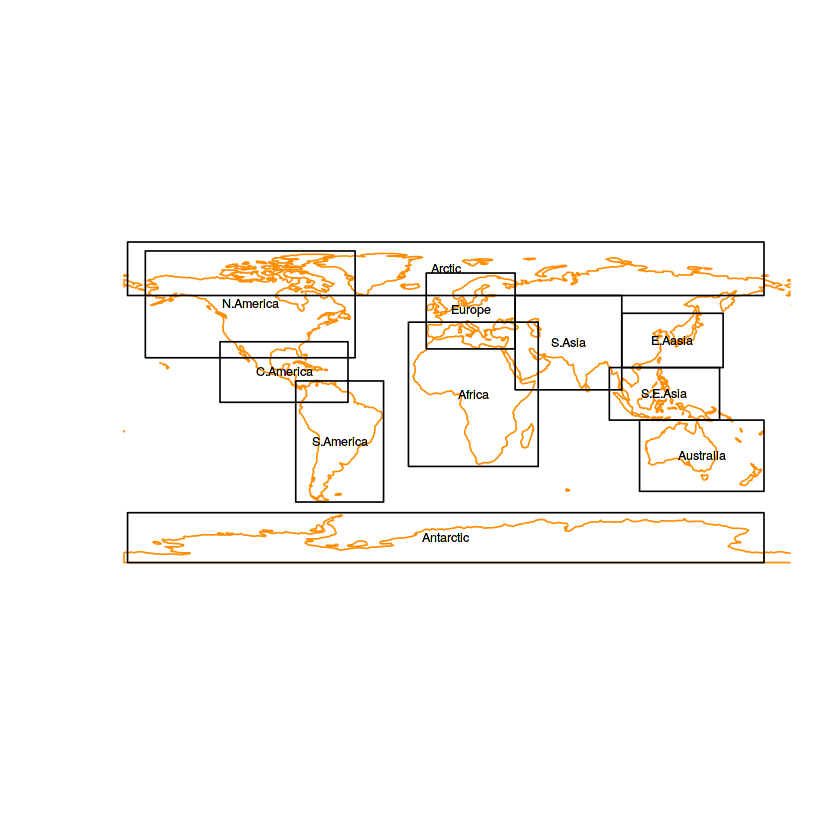

In [3]:
data(AR6_WGI_AtlasSynthesisRegions)
plot(coastLines[[2]], col = "darkorange")
plot(AR6_WGI_AtlasSynthesisRegions, add = TRUE)
text(x = coordinates(AR6_WGI_AtlasSynthesisRegions)[,1],
    y = coordinates(AR6_WGI_AtlasSynthesisRegions)[,2],
    labels = names(AR6_WGI_AtlasSynthesisRegions), cex = 0.6)

In this example we select "S.E.Asia" from `AR6_WGI_AtlasSynthesisRegions` as target region:

In [4]:
region <- "E.Aasia"  # <== Change the analysis target region 

lon <- bbox(AR6_WGI_AtlasSynthesisRegions[region])[1,]
lat <- bbox(AR6_WGI_AtlasSynthesisRegions[region])[2,]

### 1.3. Selecting the variable and season

Besides the geographical region of interest, the variable and season are also specified for all subsequent calculations:

In [5]:
var    <- "tasmax"   # <== Alternative options: "tas", "tasmin", "tasmax", "precip"
season <- "Annual"   # <== Alternative options: "DJF", "MAM", "JJA", "SON"

seas <- switch(season,
               "DJF" = c(12, 1, 2),
               "MAM" = 3:5,
               "JJA" = 6:8,
               "SON" = 9:11,
               "Annual" = 1:12)

It is always recommendable to save the data that results from operations performed at different stages of the climate data loading and post-processing chain. Therefore, here we define and create the directories for saving R data objects (`*.rda`) and figures:

### 1.4. Creating output directories for saving data and figures

In [6]:
data_dir <- "data/"  # Directory for saving data
fig_dir <- "figs/"   # Directory for saving figures

dir.create(data_dir, recursive = TRUE)
dir.create(fig_dir, recursive = TRUE)

Warning message in dir.create(data_dir, recursive = TRUE):
“'data' already exists”Warning message in dir.create(fig_dir, recursive = TRUE):
“'figs' already exists”

## 2. Loading Observational Data (EWEMBI Dataset)

`climate4R` can transparently access data from the Santander Climate Data Service via the User Data Gateway (UDG). This data service provides harmonized data for a number of popular datasets in climate studies (such as gridded observations, reanalysis, and climate change projections from CMIP and CORDEX). The function `UDG.datasets` displays the full list of available datasets. These datasets can be loaded from `climate4R` just indicating the dataset name. However, registration (http://www.meteo.unican.es/udg-tap) is required in order to obtain an authorized user and password. All public datasets are available with the role "PUBLIC" which is automatically granted upon request (after accepting the different acknowledgement terms and licences holding on the datasets). The function `loginUDG` sets authorization credentials for the current R session.

In [ ]:
loginUDG(username = "YOUR_USER", password = "YOUR_PASSWORD") # UDG server Login

As observational reference dataset we will use EWEMBI (which is the reference for the ISI-MIP initiative; [more info](https://www.isimip.org/gettingstarted/details/27/)). 

In [10]:
period <- 1985:2004 # One of the GCMs has no data for Dec 2005  
obs<-loadGridData(dataset = "PIK_Obs-EWEMBI",
               var = var,
               lonLim = lon,
               latLim = lat,
               season = seas,
               years = period)

NOTE: Accessing harmonized data from a public UDG dataset
[2019-06-14 13:06:38] Defining harmonization parameters for variable "tasmax"
[2019-06-14 13:06:38] Opening dataset...
[2019-06-14 13:06:38] The dataset was successfuly opened
[2019-06-14 13:06:38] Defining geo-location parameters
[2019-06-14 13:06:38] Defining time selection parameters
[2019-06-14 13:06:39] Retrieving data subset ...
[2019-06-14 13:09:59] Done


The function `interpGrid` performs regridding from a particular `climate4R` grid towards a target spatial grid (e.g. obtained with `getGrid`). Standard bilineal and nearest neighbor interpolation methods are defined building on standard implementations from the `akima` and `fields` packages (`?interpGrid` for more details. NOTE: Conservative gridding will be included in a future version).
In particular, **we consider a 2 degrees regular grid as the common grid for all calculations.**

In [11]:
grid <- getGrid(obs)      # Obtaninig the grid from the reference (0.5 deg)
attr(grid, "resX") <- 2   # Changing the resolution to 2 deg
attr(grid, "resY") <- 2
obs2 <- interpGrid(obs, grid, method="bilinear")  # Regridding 

[2019-06-14 13:10:02] Performing bilinear interpolation... may take a while
[2019-06-14 13:11:00] Done


[2019-06-14 13:11:00] - Computing climatology...
[2019-06-14 13:11:01] - Done.


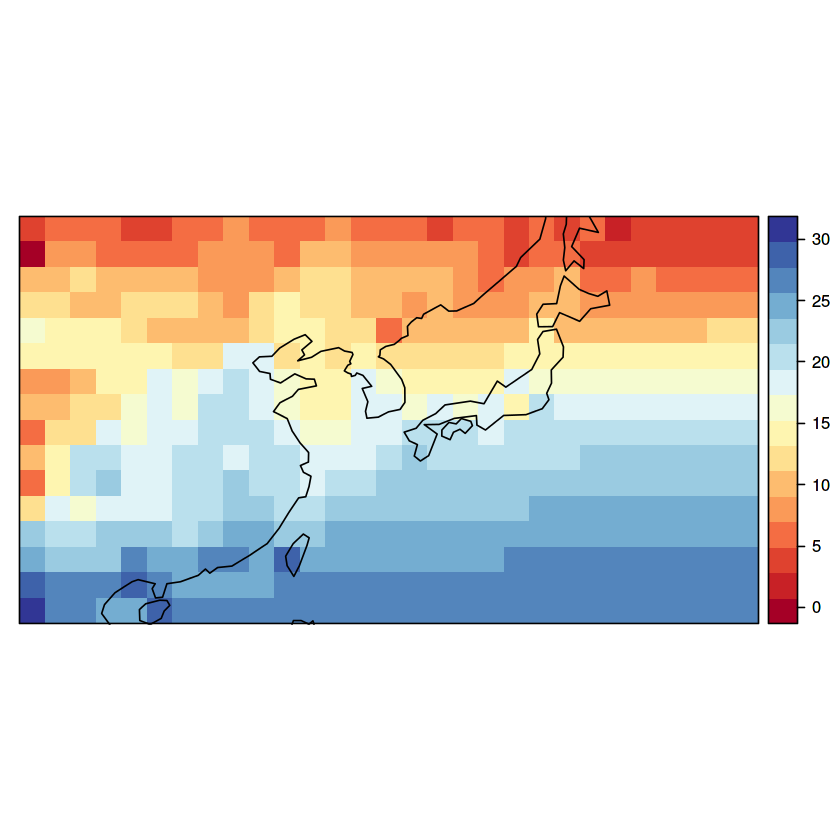

In [12]:
spatialPlot(climatology(obs2), backdrop.theme = "coastline")

The loaded and postprocessed EWEMBI data can be stored locally (in `.rda` format) for quick access in a different session, avoiding to load the data again for additional calculations of indices:

In [9]:
fileName <- paste0(data_dir, "EWEMBI_", 
       gsub(toString(region), pattern = ", ", replacement = "-"), "_", season, "_", var, "_", 
       gsub(toString(range(period)), pattern = ", ", replacement = "-"),".rda")
fileName
save(obs2, file = fileName)   # 16 MB

[1] "data/EWEMBI_E.Aasia_Annual_tasmax_1985-2004.rda"

In [10]:
# Uncomment the following line to load the previously stored *.rda object 
#load(fileName)

## 3. Loading Historical Model Data (CMIP5 subset)

Now we load data from the nine historical models data from the CMIP5 subset used the Atlas First Order Draft (FOD; see Atlas Chapter for details). First we load data from the historical scenario for the same `period` used for the observational reference.

In [11]:
source <- "CMIP5" # Options: "CMIP5", "CORDEX-AFR44"
scenario <- "historical"  # Options: "historical", "rcp45", "rcp85"
models <- UDG.datasets(pattern = paste0(source, ".*", scenario))$name
models

[1] "CMIP5_CanESM2_r1i1p1_historical"     
 [2] "CMIP5_CNRM-CM5_r1i1p1_historical"    
 [3] "CMIP5_IPSL-CM5A-MR_r1i1p1_historical"
 [4] "CMIP5_MIROC-ESM_r1i1p1_historical"   
 [5] "CMIP5_GFDL-ESM2M_r1i1p1_historical"  
 [6] "CMIP5_MPI-ESM-MR_r1i1p1_historical"  
 [7] "CMIP5_MPI-ESM-LR_r1i1p1_historical"  
 [8] "CMIP5_HadGEM2-ES_r1i1p1_historical"  
 [9] "CMIP5_EC-EARTH_r12i1p1_historical"   
[10] "CMIP5_NorESM1-M_r1i1p1_historical"

In [12]:
#Removing "CMIP5_MPI-ESM-MR" to avoid model duplicity
models <- models[-6]

In [16]:
hist <- lapply(models, function(x)
  loadGridData(dataset = x,
               var = var,
               lonLim = lon,
               latLim = lat,
               season = seas,
               years = period))

NOTE: Accessing harmonized data from a public UDG dataset
[2019-06-14 13:11:03] Defining harmonization parameters for variable "tasmax"
[2019-06-14 13:11:03] Opening dataset...
[2019-06-14 13:11:23] The dataset was successfuly opened
[2019-06-14 13:11:23] Defining geo-location parameters
[2019-06-14 13:11:23] Defining time selection parameters
[2019-06-14 13:11:23] Retrieving data subset ...
[2019-06-14 13:11:29] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2019-06-14 13:11:29] Defining harmonization parameters for variable "tasmax"
[2019-06-14 13:11:29] Opening dataset...
[2019-06-14 13:11:48] The dataset was successfuly opened
[2019-06-14 13:11:48] Defining geo-location parameters
[2019-06-14 13:11:48] Defining time selection parameters
[2019-06-14 13:11:48] Retrieving data subset ...
[2019-06-14 13:12:07] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2019-06-14 13:12:07] Defining harmonization parameters for variable "tasmax"
[2019-06-14 13:12:07

In [17]:
# Get temporal intersection of all members:
hist <- intersectGrid(hist, type = "temporal", which.return = 1:length(hist))

In [18]:
# Interpolation to the reference two-degrees grid
hist <- lapply(hist, function(x) interpGrid(x, grid, method="bilinear"))
# Ensemble building (multi-member grid)                
hist <- bindGrid(hist, dimension = "member")

Warning message in interpGrid(x, grid, method = "bilinear"):
“The new longitudes are outside the data extent”Warning message in interpGrid(x, grid, method = "bilinear"):
“The new latitudes are outside the data extent”[2019-06-14 13:26:02] Performing bilinear interpolation... may take a while
[2019-06-14 13:26:52] Done
[2019-06-14 13:26:52] Performing bilinear interpolation... may take a while
[2019-06-14 13:27:43] Done
[2019-06-14 13:27:43] Performing bilinear interpolation... may take a while
[2019-06-14 13:28:34] Done
Warning message in interpGrid(x, grid, method = "bilinear"):
“The new longitudes are outside the data extent”Warning message in interpGrid(x, grid, method = "bilinear"):
“The new latitudes are outside the data extent”[2019-06-14 13:28:34] Performing bilinear interpolation... may take a while
[2019-06-14 13:29:24] Done
Warning message in interpGrid(x, grid, method = "bilinear"):
“The new longitudes are outside the data extent”[2019-06-14 13:29:24] Performing bilinear int

Note that the metadata for the members is created by default (`Member_1, Member_2, ...`):

In [19]:
str(hist)

List of 6
 $ Variable           :List of 2
  ..$ varName: chr "tasmax"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi TRUE
  ..- attr(*, "description")= chr "Daily Maximum Near-Surface Air Temperature"
  ..- attr(*, "units")= chr "degC"
  ..- attr(*, "longname")= chr "maximum 2-m air temperature"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
  ..- attr(*, "subset")= chr "time"
  ..- attr(*, "time_subset")= chr "intersectGrid.time"
 $ Data               : num [1:9, 1:7160, 1:16, 1:29] NA 25.9 18 NA NA ...
  ..- attr(*, "dimensions")= chr [1:4] "member" "time" "lat" "lon"
 $ xyCoords           :List of 2
  ..$ x: num [1:29] 100 102 104 106 108 ...
  ..$ y: num [1:16] 19.2 21.2 23.2 25.2 27.2 ...
  ..- attr(*, "resX")= num 2
  ..- attr(*, "resY")= num 2
  ..- attr(*, "projection")= chr "LatLonProjection"
  ..- attr(*, "interpolation")= chr "bilinear"
 $ Dates              :List of 2

We can change the member names in the grid easily using the list of model names (object `models`). 
In this case, we opt to shorten the name using function `gsub`:

In [20]:
modelNames <- gsub(models, pattern = "_r1.*", replacement = "")
modelNames

[1] "CMIP5_CanESM2"      "CMIP5_CNRM-CM5"     "CMIP5_IPSL-CM5A-MR"
[4] "CMIP5_MIROC-ESM"    "CMIP5_GFDL-ESM2M"   "CMIP5_MPI-ESM-LR"  
[7] "CMIP5_HadGEM2-ES"   "CMIP5_EC-EARTH"     "CMIP5_NorESM1-M"

The internal plotting function called by `spatialPlot` is not able to interpret "-" in the names, therefore, we use `gsub` again to replace "-" with "." 

In [21]:
modelNames <- gsub(modelNames, pattern = "-", replacement = ".")

Finally, the names are assigned to the grid:

In [22]:
hist$Members <- modelNames

[2019-06-14 13:33:43] - Computing climatology...
[2019-06-14 13:33:44] - Done.


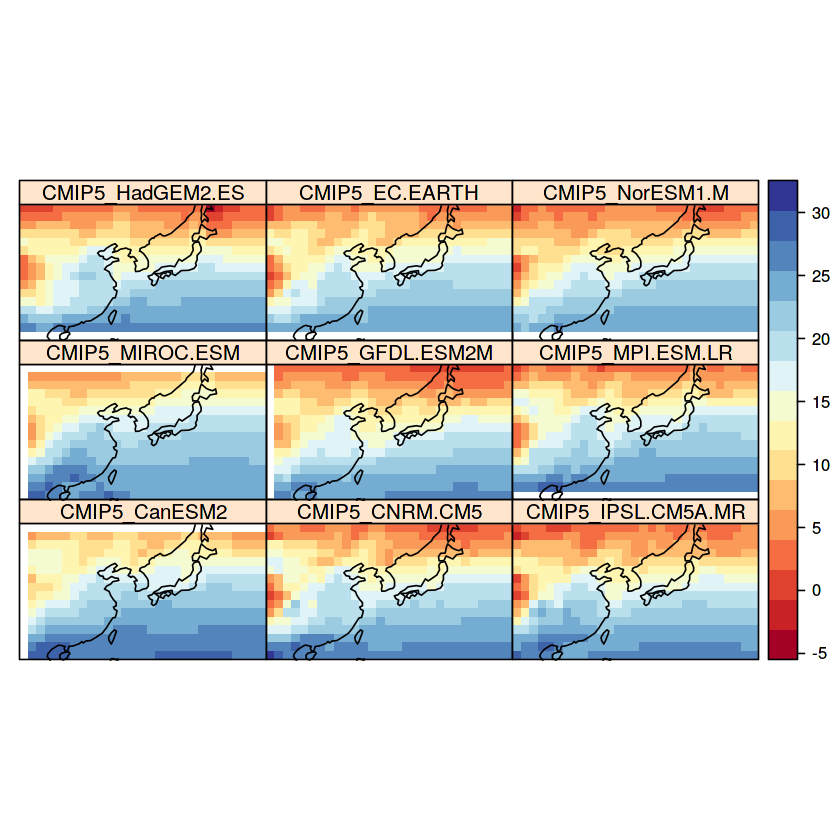

In [23]:
spatialPlot(climatology(hist),backdrop.theme = "coastline")

In [24]:
hist.ens <- aggregateGrid(hist, aggr.mem = list(FUN = "mean", na.rm = TRUE))

[2019-06-14 13:33:46] - Aggregating members...
[2019-06-14 13:34:04] - Done.


[2019-06-14 13:34:04] - Computing climatology...
[2019-06-14 13:34:04] - Done.


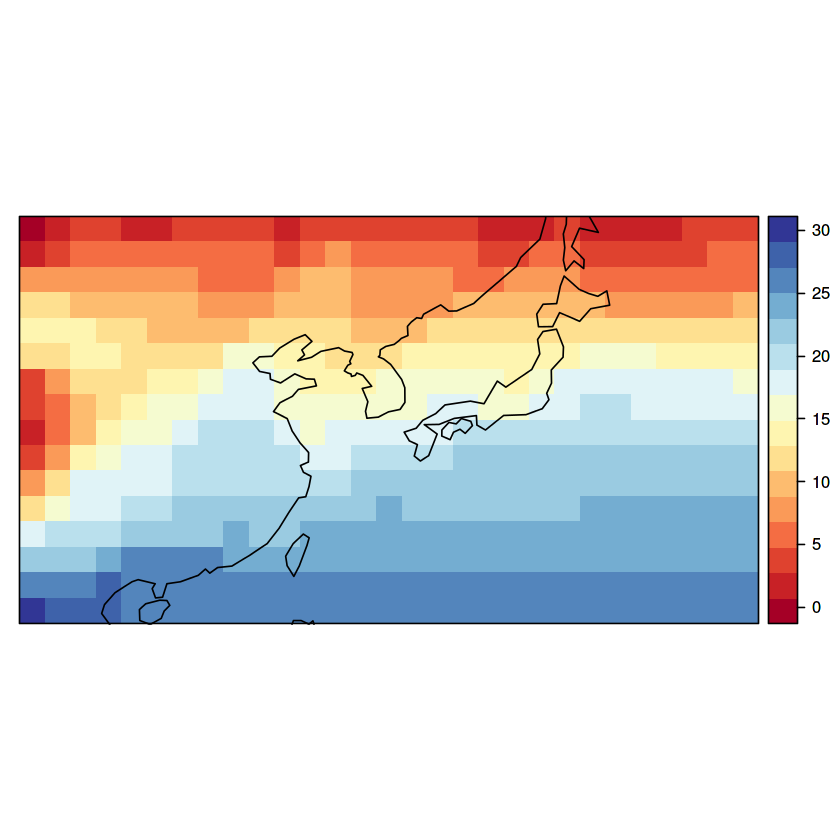

In [25]:
spatialPlot(climatology(hist.ens), backdrop.theme = "coastline")

In [13]:
fileName <- paste0(data_dir, source, "_", scenario, "_",
                   gsub(toString(region), pattern = ", ", replacement = "-"), "_", 
                   season, "_", var, "_", 
                   gsub(toString(range(period)), pattern = ", ", replacement = "-"),".rda")
fileName

[1] "data/CMIP5_historical_E.Aasia_Annual_tasmax_1985-2004.rda"

In [14]:
save(hist, file = fileName)
# Uncomment the following line (and comment the above) to load the *.rda 
#load(fileName)

## 4. Loading Future Projections (RCP8.5 time-slice)

In [15]:
period <- 2081:2100
scenario <- "rcp85" # "rcp45"
models <- UDG.datasets(pattern = paste0(source, ".*", scenario))$name
models <- models[-6]
models

[1] "CMIP5_CanESM2_r1i1p1_rcp85"      "CMIP5_CNRM-CM5_r1i1p1_rcp85"    
[3] "CMIP5_IPSL-CM5A-MR_r1i1p1_rcp85" "CMIP5_MIROC-ESM_r1i1p1_rcp85"   
[5] "CMIP5_GFDL-ESM2M_r1i1p1_rcp85"   "CMIP5_MPI-ESM-LR_r1i1p1_rcp85"  
[7] "CMIP5_HadGEM2-ES_r1i1p1_rcp85"   "CMIP5_EC-EARTH_r12i1p1_rcp85"   
[9] "CMIP5_NorESM1-M_r1i1p1_rcp85"

In [30]:
fut <- lapply(models, function(x)
  loadGridData(dataset = x,
               var = var,
               lonLim = lon,
               latLim = lat,
               season = seas,
               years = period))
fut <- intersectGrid(fut, type = "temporal", which.return = 1:length(fut))
fut <- lapply(fut, function(x) interpGrid(x, grid, method="bilinear"))
# Ensemble building (multi-member grid)                
fut <- bindGrid(fut, dimension = "member")
fut$Members <- modelNames
fut.ens <- aggregateGrid(fut, aggr.mem = list(FUN = "mean", na.rm = TRUE))

NOTE: Accessing harmonized data from a public UDG dataset
[2019-06-14 13:45:57] Defining harmonization parameters for variable "tasmax"
[2019-06-14 13:45:57] Opening dataset...
[2019-06-14 13:45:57] The dataset was successfuly opened
[2019-06-14 13:45:57] Defining geo-location parameters
[2019-06-14 13:45:57] Defining time selection parameters
[2019-06-14 13:45:57] Retrieving data subset ...
[2019-06-14 13:46:05] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2019-06-14 13:46:05] Defining harmonization parameters for variable "tasmax"
[2019-06-14 13:46:05] Opening dataset...
[2019-06-14 13:46:42] The dataset was successfuly opened
[2019-06-14 13:46:42] Defining geo-location parameters
[2019-06-14 13:46:42] Defining time selection parameters
[2019-06-14 13:46:42] Retrieving data subset ...
[2019-06-14 13:47:09] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2019-06-14 13:47:09] Defining harmonization parameters for variable "tasmax"
[2019-06-14 13:47:09

[2019-06-14 16:18:28] - Computing climatology...
[2019-06-14 16:18:28] - Done.


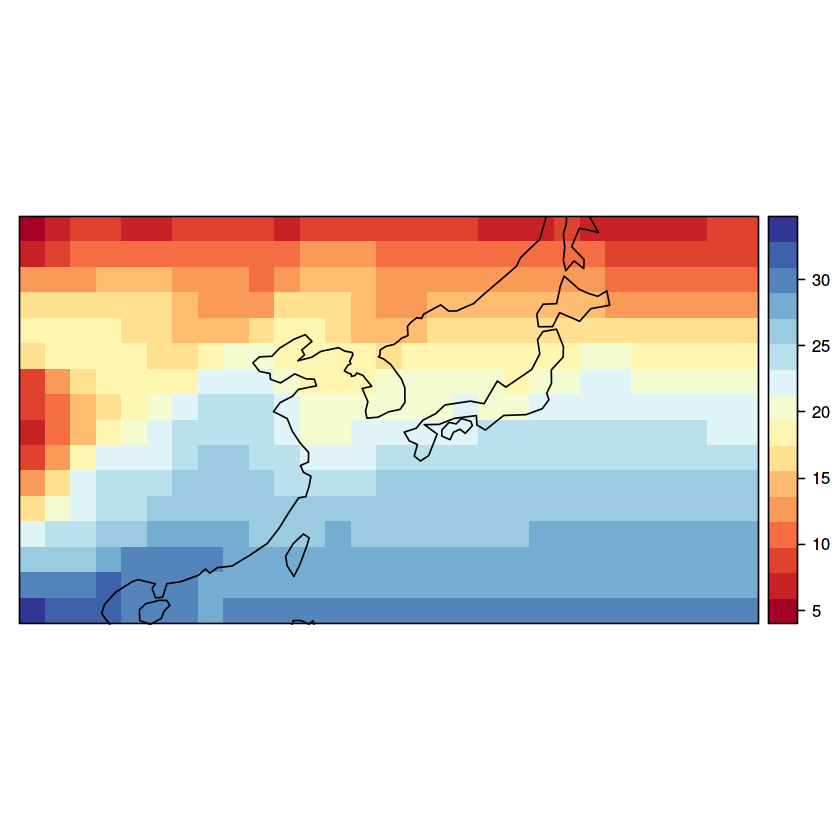

In [31]:
spatialPlot(climatology(fut.ens),backdrop.theme = "coastline")

In [16]:
fileName <- paste0(data_dir, source, "_", scenario, "_",
                   gsub(toString(region), pattern = ", ", replacement = "-"), "_", 
                   season, "_", var, "_", 
                   gsub(toString(range(period)), pattern = ", ", replacement = "-"),".rda")
fileName

[1] "data/CMIP5_rcp85_E.Aasia_Annual_tasmax_2081-2100.rda"

In [17]:
save(fut, file = fileName)
# Uncomment the following line (and comment the above) to load the *.rda 
#load(fileName)

## 5. Calculation of (extreme) Indices

There are two packages to compute indices within the climate4R framework:
* **`climate4R.climdex`** to compute an **'ETCCDI'** index (using the external `climdex` package via a wrapper). Function `climdexShow` displays available indices. Index calculation is performed by function `climdexGrid`.
* **`climate4R.indices`** to compute specific indices used in a variety of projects (incluing IPCC reports). Function `indexShow` displays available indices. Index calculation is performed by function `indexGrid`.

In [ ]:
library(climate4R.climdex)
climdexShow()

In [18]:
library(climate4R.indices)
indexShow()

climate4R.indices version 0.0.1 (2019-04-30) is loaded
Use 'indicesShow()' for an overview of the available ETCCDI indices


code,longname,indexfun,tn,tx,tm,pr,units,description
FD,Number_of_frost_days,tn.th,1,0,0,0,days,Count_of_days_when_TN<0degC
TNth,Number_of_cold_days,tn.th,1,0,0,0,days,Count_of_days_when_TN<THdegC
TXth,Number_of_hot_days,tx.th,0,1,0,0,days,Count_of_days_when_TX>THdegC
GDD,Growing_Degree_Days,gdd.th,0,0,1,0,degC,Accumulated_sum_of_degrees_of_and_when_TM>THdegC
CDD,Cooling_Degree_Days,cdd.th,1,1,1,0,days,Count_of_days_being_TH=22degC
HDD,Heating_Degree_Days,hdd.th,1,1,1,0,days,Count_of_days_being_TH=15.5degC
P,Percentile,percentile,0,0,0,0,NA,Climate_value_or_percentile
dt_st_rnagsn,first_Agronomic_Season_start_date,agroindexFAO,1,1,0,1,NA,first_Agronomic_Season_start_date
nm_flst_rnagsn,Number_of_false_Agronomic_Season_starts,agroindexFAO,1,1,0,1,NA,Number_of_false_starts
dt_fnst_rnagsn,Final_Agronomic_Season_start_date,agroindexFAO,1,1,0,1,NA,Final_start_date


In [ ]:
?percentile

### 5.1. Index Calculation

In this example we compute a particular index used in the Atlas FOD.   

In [34]:
indcode <- "P"
hist.ind <- indexGrid(tx = hist, index.code = indcode, time.resolution = "climatology", percent = 90)

[2019-06-14 17:52:50] Calculating P ...
[2019-06-14 17:52:51] Done


In [33]:
fut.ind <- indexGrid(tx = fut, index.code = indcode, time.resolution = "climatology", percent = 90)

[2019-06-14 17:52:38] Calculating P ...
[2019-06-14 17:52:40] Done


Lets plot the temporal series for Chongqing (`lonLim = 106`, `latLim = 29.5`) for a preliminary visualization:

In [36]:
#GRAPHICAL PARAMETERS 
#color palettes
pal <- colorRampPalette(brewer.pal(n = 9, name = "Reds"))(22) # For pr: brewer.pal(n = 10, "BrBG")
pal.sd <- colorRampPalette(brewer.pal(n = 9, name = "Greys"))(22) # For pr: brewer.pal(n = 10, "BrBG")       
setmm <- c(5, 45)      #limits for the deltas in spatialPlot
cuts <- seq(5, 45, 2)  #legend cuts in spatialPlot

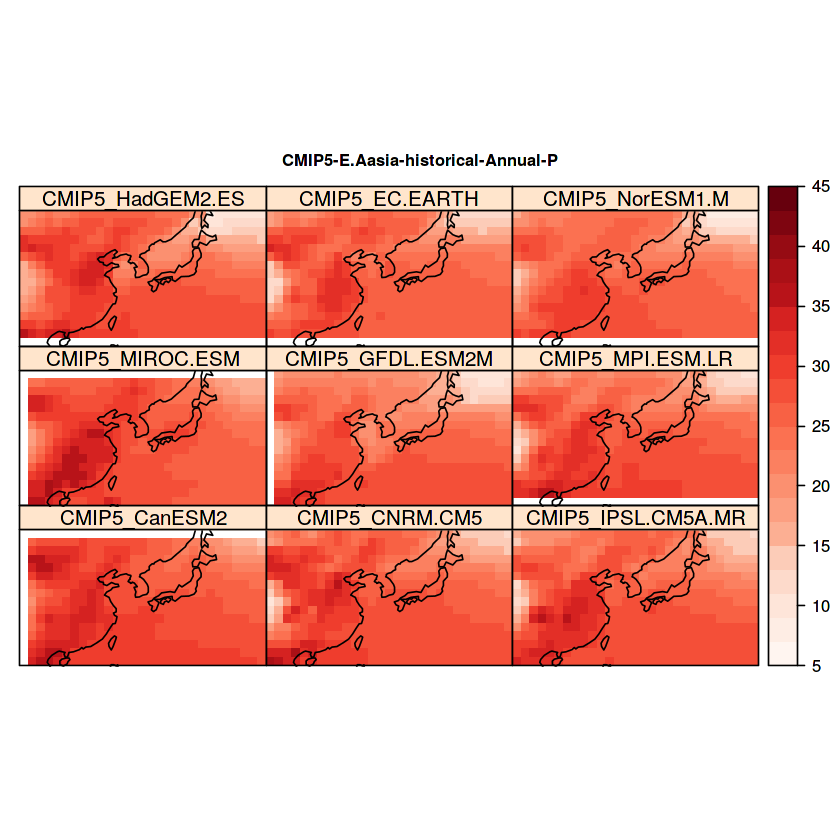

In [38]:
# Map of the historical index
spatialPlot(hist.ind,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", gsub(toString(region), pattern = ", ", replacement = "-"), "-", "historical", "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")

[2019-06-14 17:53:25] - Aggregating members...
[2019-06-14 17:53:25] - Done.


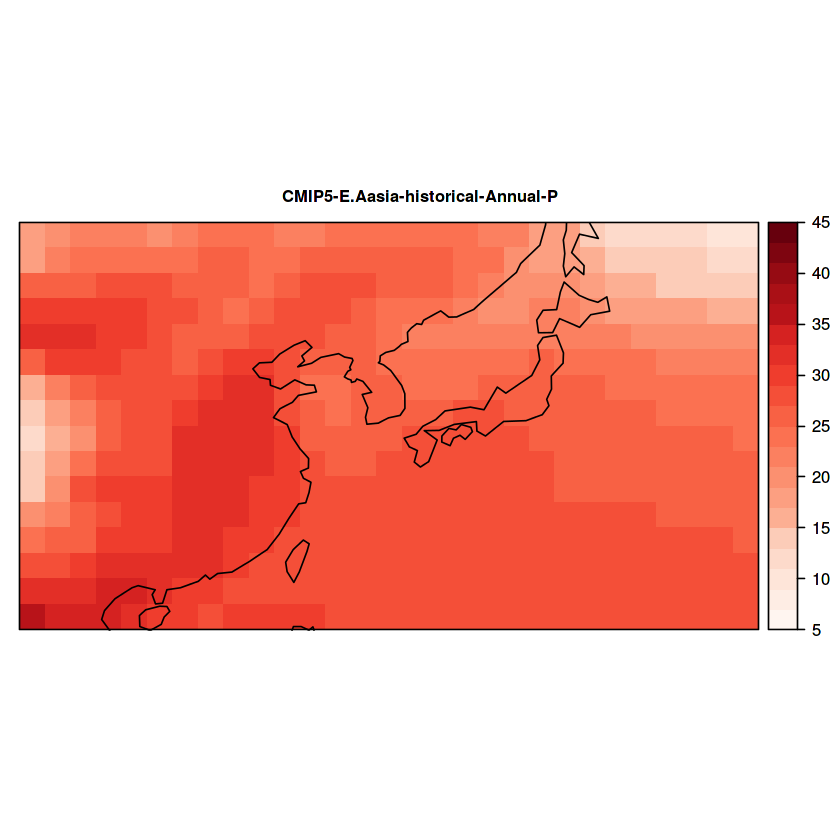

In [39]:
# Map of the historical ensemble mean index
hist.ind.ens <- aggregateGrid(hist.ind, aggr.mem = list(FUN = "mean", na.rm = TRUE))
spatialPlot(hist.ind.ens,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", gsub(toString(region), pattern = ", ", replacement = "-"), "-", "historical", "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")

Therefore, the caption of the above figure is "Absolute daily maximum temperature amounts corresponding to the 90th percentile (P90, defining “warm nights” and “warm days”, respectively) in the historical period".

[2019-06-14 17:53:32] - Aggregating members...
[2019-06-14 17:53:32] - Done.


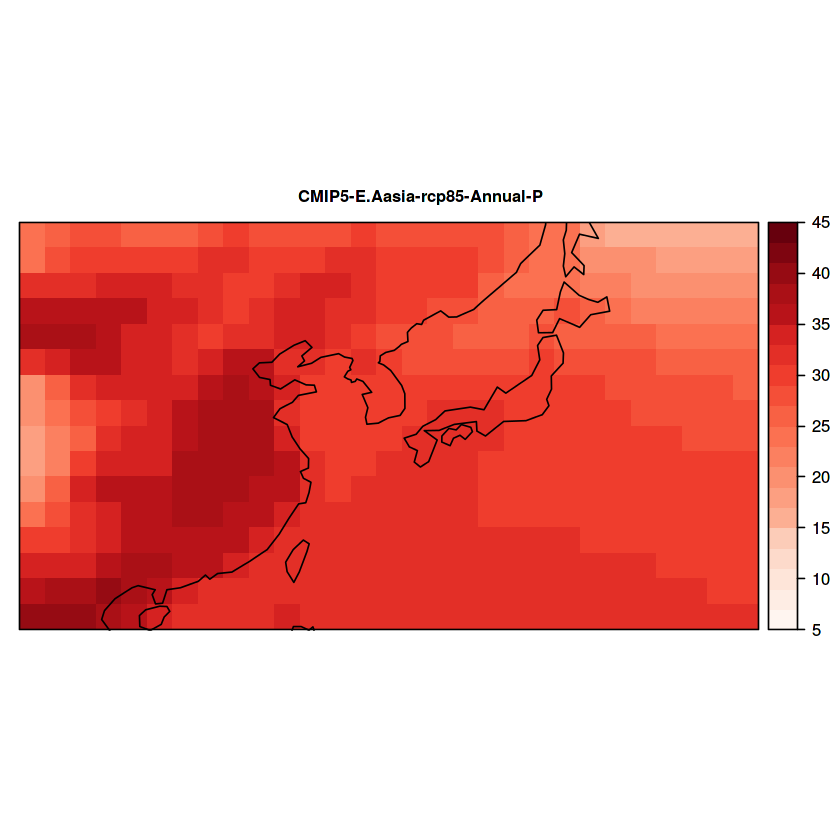

In [40]:
# Map of the future ensemble mean index
fut.ind.ens <- aggregateGrid(fut.ind, aggr.mem = list(FUN = "mean", na.rm = TRUE))
spatialPlot(fut.ind.ens,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", gsub(toString(region), pattern = ", ", replacement = "-"), "-", scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")

Therefore, the caption of the above figure is "Absolute daily maximum temperature amounts corresponding to the 90th percentile (P90, defining “warm nights” and “warm days”, respectively) in the future period".

### Climate change signal

The climate change signal in the FOD is shown as the changes in frequency of the 90th percentile of the maximum temperature (corresponding to the historical period) for the future 2081-2100 period (RCP8.5) defined as exceeding the historical P90 threshold (results shown as relative change, %). Thus, here we apply again `indexGrid` to the future maximum temperature (object `fut`) but using the historical data as `baseline`. 

In [41]:
freq.fut <- indexGrid(tx = fut, index.code = indcode, baseline = hist, time.resolution = "climatology", percent = 90)

[2019-06-14 17:53:58] Calculating P ...
[2019-06-14 17:54:06] Done


By using the `baseline` argument in `indexGrid` and by providing a percentage to the `percent` argument, we are calculating the maximum temperature of the 90 percentile for the historical period, and then, using those temperature values to calculate the corresponding percentile in the future throughout the entire region.

To calculate de "delta", the following formula was applied in the FOD:

                    relative.delta = 100 - future_percentile - 10

The 10 value corresponds to the frequency in the historical period (i.e. 100 - 90).

In order to apply this formula, and given that function `gridArithmetics` only allows `grid` objects as first argument, we first create a template `grid` (object `template`) by means of function `gridArithmetics`, resulting in a `grid` where all values are 100. Afterwards, we apply the previously shown formula using again `gridArithmetics`.

In [42]:
template <- gridArithmetics(freq.fut,  0, 100, operator = c("*", "+"))
freq.fut.delta <- gridArithmetics(template, freq.fut, 10, operator = c("-", "-"))

In [44]:
#GRAPHICAL PARAMETERS 
#color palettes
pal <- colorRampPalette(rev(brewer.pal(n = 10, name = "RdBu")))(24)
pal.sd <- colorRampPalette(brewer.pal(n = 9, name = "Greys"))(24)       

setmm <- c(-60, 60)  #limits for the deltas in spatialPlot
setmmsd <- c(0, 60)  #limits for the delta deviations
lllim <- c(0, 30)    #limits for the deltas in temporalPlot
cuts <- seq(-60, 60, 5)  #legend cuts in spatialPlot
cutssd <- seq(0, 60, 5)   #legend cuts in spatialPlot for deviation maps

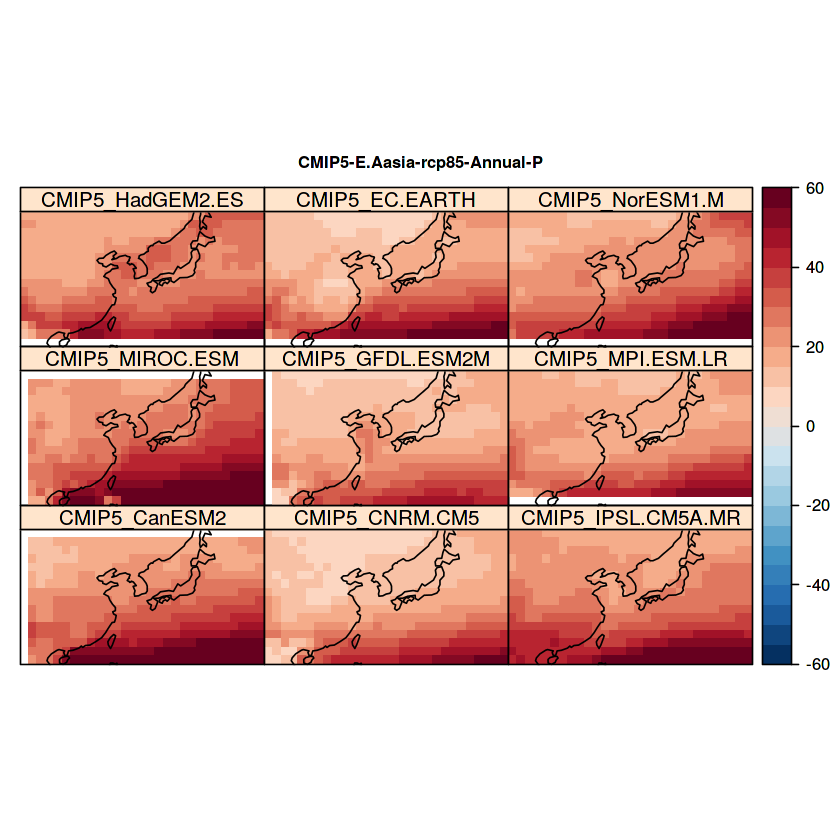

In [45]:
spatialPlot(freq.fut.delta,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", 
                        gsub(toString(region),pattern = ", ", replacement = "-"), "-", 
                        scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")

[2019-06-14 17:55:14] - Aggregating members...
[2019-06-14 17:55:14] - Done.


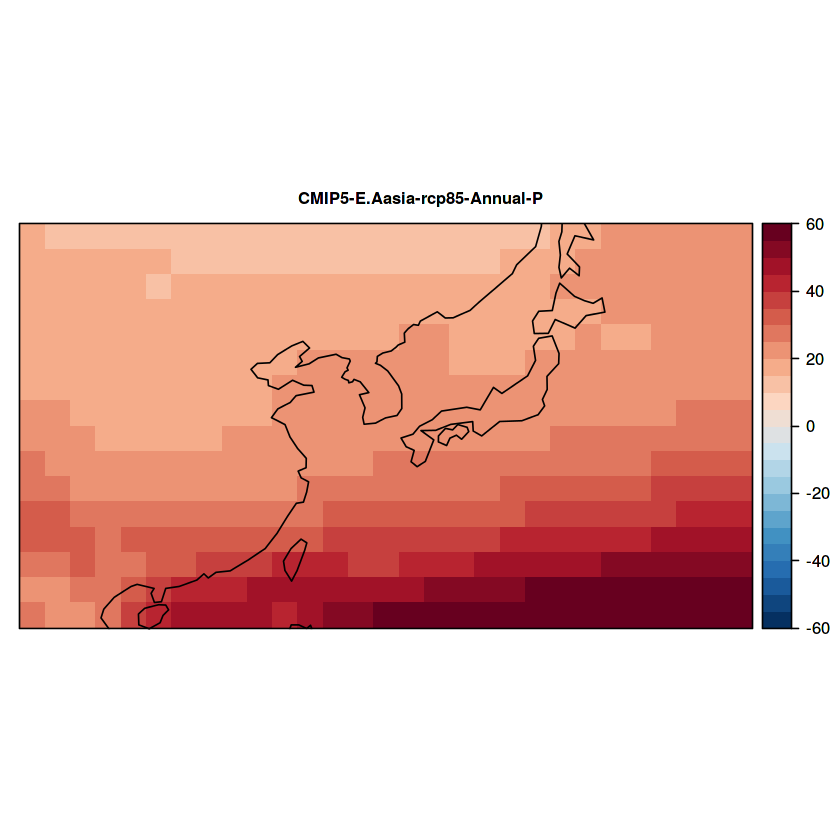

In [46]:
# Map of the ensemble mean delta 
delta.ens <- aggregateGrid(freq.fut.delta, aggr.mem = list(FUN = "mean", na.rm = TRUE))
spatialPlot(delta.ens,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", 
                    gsub(toString(region), pattern = ", ", replacement = "-"), "-", 
                    scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")

Therefore, the caption of the above figure is "Changes in frequency of the 90th percentile of the maximum temperature (corresponding to the historical period) for the future 2081-2100 period (RCP8.5) defined as exceeding the historical P90 threshold (results shown as relative change, %)".

[2019-06-14 18:10:28] - Aggregating members...
[2019-06-14 18:10:28] - Done.


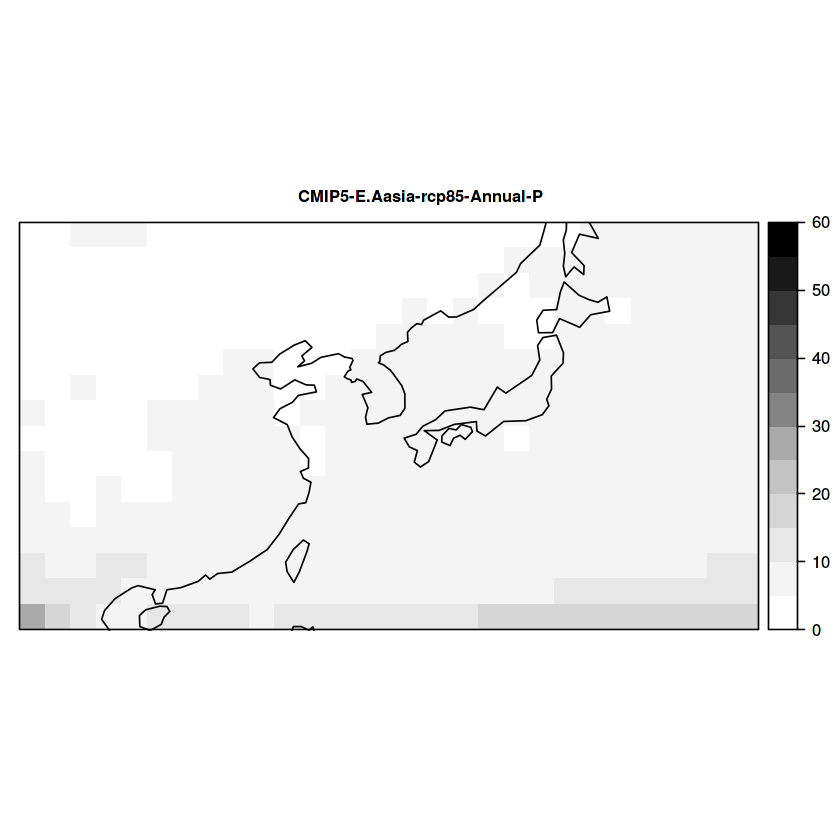

In [52]:
# Map of the ensemble delta spread
delta.sd <- aggregateGrid(freq.fut.delta, aggr.mem = list(FUN = "sd", na.rm = TRUE))
spatialPlot(delta.sd,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", 
                    gsub(toString(region), pattern = ", ", replacement = "-"), "-", 
                    scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmmsd[2],
            set.min = setmmsd[1],
            at = cutssd,
            col.regions = pal.sd,
            backdrop.theme = "coastline")

## 6. Bias Correction 



Bias correction is performed by the `biasCorrection` function, from the `downscaleR` package. This function includes a number of standard bias correction methods:

* local (mean/variance) scaling,
* parametric (binomial+gamma) quantile mapping (PQM).
* PQM with generalized Pareto for the extremes (GPQM).
* empirical quantile mapping, with different extrapolation options (EQM).

All methods can be applied separately to each calendar day (or block of days) using a moving window (e.g. `window = c(30, 30)` for a 30-day moving window). The methods PQM, GPQM and EQM have contributed to the VALUE intercomparisson initiative and are described and validated in Gutiérrez et al. 2019 DOI: 10.1002/joc.5462 (see ?biasCorrection or the wiki for more details on this function). In the following example we apply the standard EQM method; note that no moving window is applied in this case to reduce the computation time.


In [48]:
# Historical
hist.bc <- biasCorrection(y = obs2, x = hist, method = "eqm", window = c(30, 30))

[2019-06-14 17:56:05] Argument precipitation is set as FALSE, please ensure that this matches your data.
[2019-06-14 17:56:10] Number of windows considered: 11...
[2019-06-14 17:56:10] Bias-correcting 9 members separately...
[2019-06-14 17:57:41] Done.


In [49]:
# Future
fut.bc <- biasCorrection(y = obs2, x = hist, newdata = fut, method = "eqm", 
                         window = c(30, 30), extrapolation = "constant")

[2019-06-14 17:57:45] Argument precipitation is set as FALSE, please ensure that this matches your data.
[2019-06-14 17:57:49] Number of windows considered: 11...
[2019-06-14 17:57:49] Bias-correcting 9 members separately...
[2019-06-14 17:59:18] Done.


In [50]:
freq.fut.bc <- indexGrid(tx = fut.bc, index.code = indcode, baseline = hist.bc, time.resolution = "climatology", percent = 90)

template <- gridArithmetics(freq.fut.bc,  0, 100, operator = c("*", "+"))
freq.fut.delta.bc <- gridArithmetics(template, freq.fut.bc, 10, operator = c("-", "-"))

[2019-06-14 17:59:19] Calculating P ...
[2019-06-14 17:59:28] Done


[2019-06-14 18:04:26] - Aggregating members...
[2019-06-14 18:04:26] - Done.


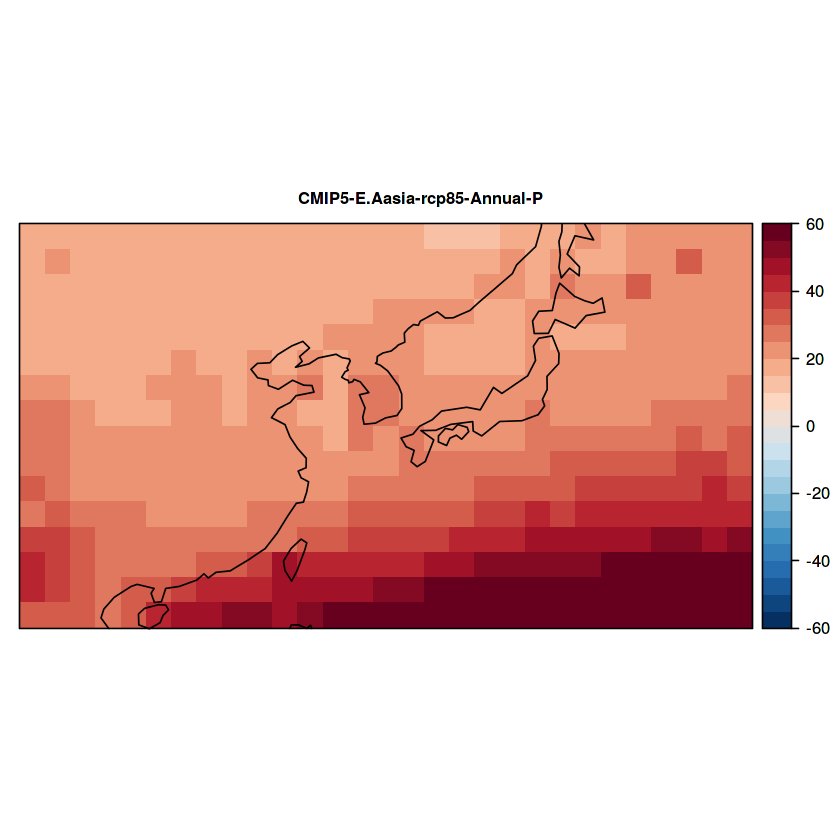

In [51]:
# Map of the ensemble mean bias corrected delta 
delta.ens.bc <- aggregateGrid(freq.fut.delta.bc, aggr.mem = list(FUN = "mean", na.rm = TRUE))
spatialPlot(delta.ens.bc,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", 
                     gsub(toString(region), pattern = ", ", replacement = "-"), "-", 
                     scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")

## 7. How to export the figures

Figures can be easily exported as *.pdf files by applying function `pdf` before the plotting function and function `dev.off()` after the plotting function. The most important arguments of function `pdf` are `file` (the path of the output pdf file), `width` and `height`. In this example we create object `output.fig` to specify the path of the output pdf file: 

In [82]:
# Specifications to save figures/data to local folders (if required)
fig.height <- 8
fig.width <- 8

In [83]:
output.fig <- "" # write here the output file name

For example, we here use function `paste0` to create the file name:

In [87]:
output.fig <- paste0(fig_dir, source, "_", 
        gsub(toString(region), pattern = ", ", replacement = "-"), "_", 
        scenario, "_", season, "_", paste0(indcode, "P90_delta"),"_", 
        gsub(toString(range(period)), pattern = ", ", replacement = "-"),".pdf")
output.fig

[1] "figs/CMIP5_E.Aasia_rcp85_Annual_PP90_delta_2081-2100.pdf"

In [88]:
pdf(file = output.fig, width = 18, height = 5)
spatialPlot(delta.ens.bc,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", 
                     gsub(toString(region), pattern = ", ", replacement = "-"), "-", 
                     scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")
dev.off()

[2019-06-14 16:48:21] - Computing climatology...
[2019-06-14 16:48:21] - Done.


png 
  2

Go to the output directory and check that the figure has been created (If needed, download the figure to your local machine). You can add the application of functions `pdf` and `dev.off()` to the rest of the plotting chunks in this or other scripts. 

## NOTE: Use function `help` for a detailed description of the usage of a function, for instance:

In [ ]:
help(aggregateGrid)